In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
from shapely.geometry import Point
from shapely.geometry import LineString
import pygeos
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [68]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

# Define a helper function to generate pairs of consecutive elements in a list
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


# Define a helper function to generate permutations
def permutations(iterable, r=None):
   # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return 
        
        
# Retrive data from OSM and get the geographic data of tram
def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    pygeos_geo = pygeos.from_wkt(feature.geometry().ExportToWkt())
                    if pygeos_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(pygeos_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}    
    
def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all railway linestrings.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])        

def tram_network(osm_path):
    """
    Extracts tram network data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing tram network data extracted from the OpenStreetMap file.
    """

    # Extract railway data from the OpenStreetMap file
    df_railway = railway(osm_path)
    
    # Filter the DataFrame to only contain tram network data
    tram = df_railway.loc[df_railway.railway == 'tram']
    
    # Return the filtered DataFrame
    return tram

# def tram_stations(osm_path):   #original version, but cannot get all tram stops
#     """
#     Function to extract tram station nodes from OpenStreetMap.  
#     Arguments:
#         *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
#     Returns:
#         *GeoDataFrame* : a geopandas GeoDataFrame with all tram station nodes.
#     """   
    
#     return (retrieve(osm_path,'points',['railway', 'tram', 'name'],**{'railway':["='tram_stop'"]}))

# def tram_stations(osm_path):  #test1
#     """
#     Function to extract tram station nodes from OpenStreetMap.  
#     Arguments:
#         *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
#     Returns:
#         *GeoDataFrame* : a geopandas GeoDataFrame with all tram station nodes.
#     """   
    
#     return (retrieve(osm_path,'points',['railway', 'tram', 'name', 'alt_name', 'public_transport'],**{'public_transport':["='stop_position'"]}))

def railway_stations(osm_path):
    """
    Function to extract tram station nodes from OpenStreetMap.  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all tram station nodes.
    """   
    
    return (retrieve(osm_path,'points',['public_transport','tram', 'name']))  #,'railway'

def tram_stations(osm_path):

    
    df_railway_stations = railway_stations(osm_path)
    
   
    tram_stations = df_railway_stations.loc[df_railway_stations.tram == 'yes']
    tram_stations = tram_stations.loc[tram_stations.public_transport == 'stop_position']
    
    return tram_stations


def routes(osm_path):
    """
    Extracts route data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing route data extracted from the OpenStreetMap file.
    """

    # Call the 'retrieve' function to extract route data from the OpenStreetMap file
    # The 'retrieve' function takes three arguments:
    # - The file path of the OpenStreetMap file
    # - A list of geometry types to extract (in this case, only multilinestrings)
    # - A list of tag keys to extract (in this case, 'route', 'name', and 'ref')
    route_data = retrieve(osm_path, 'multilinestrings', ['route', 'name', 'ref'])

    # Return the extracted route data as a Pandas DataFrame
    return route_data

def add_stations(net,station_file):
    
    station_geometries = pd.DataFrame(station_file.geometry)
    
    net.nodes = pd.concat([net.nodes,station_geometries]).reset_index(drop=True)
                           
    return net

# Pre-processing the geographic data of the subway network to obtain 'edges' and 'nodes'
def prepare_network(subway,station_file):
    """
    Prepare a subway network represented as a GeoDataFrame of LineString objects for routing.

    Args:
    - subway: a GeoDataFrame representing the subway network, with 'geometry' column containing LineString objects
    
    Returns:
    - a tuple of two DataFrames representing the edges and nodes of the prepared network

    Example:
    >>> import geopandas
    >>> subway = geopandas.read_file('subway.shp')
    >>> edges, nodes = prepare_network(subway)

    Note: This function requires the PyGEOS, NetworkX, and Pandas libraries to be installed.
    """
    # Convert the subway GeoDataFrame's 'geometry' column from Shapely objects to PyGEOS objects
    df_subway = pd.DataFrame(subway.copy())
    df_subway.geometry = pygeos.from_shapely(df_subway.geometry)

    station_file.geometry = pygeos.from_shapely(station_file.geometry)

    # Build a Network object from the subway edges
    net = Network(edges=df_subway)

    # Add endpoints to the network where edges don't intersect
    net = add_endpoints(net)
    
    # Add endpoints to the network where edges don't intersect
    #net = add_stations(net,station_file)
        
    # Split edges at new endpoints
    net = split_edges_at_nodes(net)

    # Add new endpoints where edges were split
    net = add_endpoints(net)

    # Assign unique IDs to nodes and edges
    net = add_ids(net)

    # Add missing topology information to the network's edges
    net = add_topology(net)    

    # Calculate the degree of each node in the network
    net.nodes['degree'] = calculate_degree(net)

    # Merge edges with a degree of 2
    #net = merge_edges(net)

    # Drop duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # Reset node and edge IDs after fixing topology and merging edges
    net = reset_ids(net) 

    # Add edge distances
    net = add_distances(net)

    # Merge any MultiLineString edges
    net = merge_multilinestrings(net)

    # Add travel time for each edge based on distance and average speed
    net = add_travel_time(net)
    
    # Return the edges and nodes of the prepared network
    return net.edges, net.nodes

def expand_edges(edges):
    """
    Expand a DataFrame of edges into a format that can be used with network analysis algorithms.

    Args:
    - edges: a DataFrame containing edges with columns 'from_id', 'to_id', and 'distance'

    Returns:
    - a DataFrame containing expanded edges with columns 'from_id', 'to_id', 'distance', 'weights', 'to_from', and 'from_to'

    Example:
    >>> edges = pd.DataFrame({'from_id': [0, 0, 1], 'to_id': [1, 2, 2], 'distance': [1.5, 3.2, 2.8]})
    >>> expand_edges(edges)
      from_id  to_id  distance  weights  to_from  from_to
    0       0      1       1.5        1  (0, 1)  (1, 0)
    1       0      2       3.2        3  (0, 2)  (2, 0)
    2       1      2       2.8        2  (1, 2)  (2, 1)

    Notes:
    - The 'weights' column is created by rounding the 'distance' column to the nearest integer.
    - The 'to_from' and 'from_to' columns are created to facilitate conversion between edge formats.
    """
    # Round the distance to the nearest integer and store it in a new column 'weights'
    edges['weights'] = edges['distance'].astype(int)

    # Create 'to_from' and 'from_to' columns to facilitate conversion between edge formats
    edges['to_from'] = list(zip(edges.from_id, edges.to_id))
    edges['from_to'] = list(zip(edges.to_id, edges.from_id))

    # Return the expanded edges DataFrame
    return edges


def am_tram_stations(stations):
    
# Add columns for the x and y coordinates of each station
    stations['geo_x'] = stations.geometry.x
    stations['geo_y'] = stations.geometry.y
    
    # Drop duplicate stations and rename the two 'Centraal Station' stations as 'Centraal Station_A' and 'Centraal Station_B'
    sorted_stations = stations.sort_values(by='geo_x')
    stations_drop = sorted_stations[sorted_stations['name'] != 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
    station_cetralB = sorted_stations[sorted_stations['name'] == 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
    station_cetralB.iloc[0, 3] = 'Centraal Station_B'
    # station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
    station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
    station_cetralA = pd.DataFrame(station_cetralA)
    station_cetralA.iloc[0, 3] = 'Centraal Station_A'
    
    # Create DataFrames for the stations and concatenate them into one DataFrame
    df_stations_drop = pd.DataFrame(stations_drop)
    df_station_cetralB = pd.DataFrame(station_cetralB)
    df_station_cetralA = pd.DataFrame(station_cetralA)
    tram_stations = pd.concat([df_stations_drop, df_station_cetralB, df_station_cetralA])
    
    return tram_stations

# Create s_e_tram_coordinates_pairs dataframe combining data of all stations and names of start-end stations    
def s_e_tram_coordinates(am_tram_stations, s_e_tram_station_name):
    """
    Given a GeoDataFrame `stations` containing information about tram stations and a DataFrame `s_e_tram_station_name` 
    containing pairs of tram station names, returns a new DataFrame with columns `s_name`, `e_name`, `s_coordinates_x`, 
    `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Parameters
    ----------
    stations : geopandas.GeoDataFrame
        A GeoDataFrame containing information about tram stations, including the `geometry` column with the latitude 
        and longitude coordinates of each station.
    s_e_tram_station_name : pandas.DataFrame
        A DataFrame containing pairs of tram station names, with columns `s_name` and `e_name`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_name`, `e_name`, `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and 
        `e_coordinates_y`. `s_name` and `e_name` are the names of the starting and ending tram stations, respectively, 
        and `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y` are the coordinates of the 
        starting and ending tram stations.
    """
    
    # Create s_e_tram_coordinates DataFrame by compare station names 
    df31 = pd.merge(s_e_tram_station_name, am_tram_stations, how='left', left_on='s_name', right_on='name')
    s_e_tram_coordinates = pd.merge(df31, am_tram_stations, how='left', left_on='e_name', right_on='name')
    s_e_tram_coordinates = s_e_tram_coordinates.loc[:,['s_name', 'e_name', 'geo_x_x', 'geo_y_x', 'geo_x_y', 'geo_y_y']]
    s_e_tram_coordinates.columns = ['s_name', 'e_name', 's_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y']
    
    return s_e_tram_coordinates

def s_e_coordinates_pairs(s_e_coordinates):
    """
    Given a Pandas DataFrame `s_e_coordinates` with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, 
    and `e_coordinates_y`, returns a new DataFrame with columns `s_coordinates` and `e_coordinates`.
    
    `s_coordinates` and `e_coordinates` are each a tuple of the form `(x, y)`, where `x` is the value in the 
    `s_coordinates_x` or `e_coordinates_x` column, and `y` is the value in the `s_coordinates_y` or `e_coordinates_y` 
    column.
    
    Parameters
    ----------
    s_e_coordinates : pandas.DataFrame
        A DataFrame with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_coordinates` and `e_coordinates`.
    """
    
    # Create an empty DataFrame to hold the new columns
    s_e_coordinates_pairs = pd.DataFrame()
    
    # Create the `s_coordinates` column by zipping the `s_coordinates_x` and `s_coordinates_y` columns
    s_e_coordinates_pairs['s_coordinates'] = list(zip(s_e_coordinates.s_coordinates_x, s_e_coordinates.s_coordinates_y))
    
    # Create the `e_coordinates` column by zipping the `e_coordinates_x` and `e_coordinates_y` columns
    s_e_coordinates_pairs['e_coordinates'] = list(zip(s_e_coordinates.e_coordinates_x, s_e_coordinates.e_coordinates_y))
    
    # Return the new DataFrame
    return s_e_coordinates_pairs


# Define nearest nodes with real_world coordinates of start and end points, obtain the nearest id pairs of nodes 
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a PyGEOS geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as PyGEOS Point objects
    
    Returns:
    - the id value of the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from pygeos import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
    1234

    Note: This function requires the PyGEOS and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = pygeos.STRtree(nodes.geometry)
   
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(pygeos.points(coordinate))
    elif isinstance(coordinate, pygeos.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the id value of the nearest node from the nodes GeoDataFrame
    # print(nodes.iloc[find_nearest[1]]['id'])
    return int(nodes.iloc[find_nearest[1]]['id'])

def id_pairs(coordinates_pairs, nodes):
    """
    Map the start and end coordinates to the nearest nodes in a transportation network.

    Args:
    - coordinates_pairs: a pandas DataFrame containing start and end coordinates in the network, with columns 's_coordinates', 'e_coordinates'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as PyGEOS Point objects

    Returns:
    - a pandas DataFrame containing the nearest node IDs for each start and end coordinate pair, with columns 's_id', 'e_id'

    """
    # Initialize an empty DataFrame to store the start and end node IDs
    id_pairs = pd.DataFrame(columns=['s_id','e_id'])
    pairs_num = coordinates_pairs.shape[0]
    
    # For each start and end coordinate pair, find the nearest node in the network and store the node IDs in the DataFrame
    for i in range(pairs_num):
        s_coordinate = pygeos.points(coordinates_pairs.s_coordinates[i])
        s_id = find_nearest_node(s_coordinate, nodes)
        e_coordinate = pygeos.points(coordinates_pairs.e_coordinates[i])
        e_id = find_nearest_node(e_coordinate, nodes)
        id_pairs.loc[i] = [s_id,e_id]
        
    return id_pairs


# Create a base Graph object as the basic topology network with 'edges' and 'nodes'
def create_ground_graph(edges, nodes):
    """
    Create a networkx Graph object representing a ground transportation network.

    Args:
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as PyGEOS Point objects
    
    Returns:
    - a networkx Graph object representing the ground transportation network

    Example:
    >>> import pandas as pd
    >>> import geopandas as gpd
    >>> import networkx as nx
    >>> edges = pd.read_csv('edges.csv')
    >>> nodes = gpd.read_file('nodes.shp')
    >>> G = create_ground_graph(edges, nodes)

    Note: This function requires the pandas, geopandas, and networkx libraries to be installed.
    """
    # Extract the edges from the input DataFrame and create a list of tuples with weights
    od = edges[['from_id', 'to_id', 'weights']]
    edges_list = []
    for i, row in od.iterrows():
        weight_dict = {"weight": row[2]}
        tuple_row = (row[0], row[1], weight_dict)
        edges_list.append(tuple_row)
    
    # Extract the nodes from the input GeoDataFrame and create a list of node IDs
    nodes_list = nodes.iloc[:,2].tolist()
    
    # Create an empty Graph object and add the nodes and edges
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    
    return G


# Calculate the shorted path
def shortest_path(G, start_point_id, end_point_id, edges, weight = "weight"):   # calculate the shortest path for one start_end_node id_pair
    """
    Compute the shortest path between two nodes in a given graph, along with its length and the edges that belong to the path.

    Args:
    - G: a networkx Graph object representing the graph
    - start_point_id: the ID of the node where the path starts
    - end_point_id: the ID of the node where the path ends
    - weight: the attribute used to determine the weight of the edges in the graph (default: "weight")

    Returns:
    - a tuple containing:
        - the list of nodes that form the shortest path from start_point_id to end_point_id
        - the length of the shortest path
        - a pandas DataFrame containing the edges that belong to the shortest path, with a new column 'linewidth' that is proportional to the edge weights

    Example:
    >>> import networkx as nx
    >>> import pandas as pd
    >>> G = nx.Graph()
    >>> G.add_edge(0, 1, weight=2.0)
    >>> G.add_edge(1, 2, weight=1.0)
    >>> G.add_edge(0, 2, weight=3.0)
    >>> path, length, edges = shortest_path(G, 0, 2)
    >>> print(path)
    [0, 1, 2]
    >>> print(length)
    3.0
    >>> print(edges)
       from_id  to_id  weights  to_from  from_to  linewidth
    0        0      1      2.0      NaN      1.0        1.0
    2        1      2      1.0      2.0      NaN        1.0
    """
    
    # Compute the shortest path and its length using the networkx library
    path_s_e = nx.shortest_path(G, source=start_point_id, target=end_point_id, weight= weight)
    length_s_e = nx.shortest_path_length(G, source=start_point_id, target=end_point_id, weight= weight)
    
   
    # Select the edges that belong to the shortest path and compute their linewidth based on their weight
    short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
    #short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))   # test 'linewidth' with one pair and there is no practical significance camparing with several routes and can be left out of the calculation 
    
    # Return the computed values as a tuple
    return path_s_e, length_s_e, short_path_edges

def all_shortest_paths(id_pairs,edges):
    """
    Find all shortest paths between start and end nodes and extract corresponding edges.

    Args:
    - id_pairs: a pandas DataFrame containing start and end node IDs for each path
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'

    Returns:
    - shortest_path_pairs: a pandas DataFrame containing the edges for all shortest paths found

    Example:
    >>> shortest_path_pairs = all_shortest_paths(id_pairs, edges)

    Note: This function requires the pandas and networkx libraries to be installed.
    """
    row_num = id_pairs.shape[0]
    shortest_path_pairs = pd.DataFrame()
    
    for i in range(row_num):
        s_id = id_pairs.loc[i,'s_id']
        e_id = id_pairs.loc[i,'e_id']
        try:
            # Find shortest path between start and end nodes
            path_s_e = nx.shortest_path(G, source=s_id, target=e_id, weight= "weight")
            # Extract edges corresponding to shortest path
            short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
            shortest_path_pairs = pd.concat([shortest_path_pairs,short_path_edges])
        except nx.NetworkXNoPath:
            # If no path exists between start and end nodes, continue to next pair
            # print(f"No path found between {s_id} and {e_id}")
            continue
        #print(path_s_e, length_s_e)
        
    return shortest_path_pairs


# calculates the number of repetitions of each used edge and add the number to 'edges' with column of 'count_weight'
def edges_with_count_weight(shortest_path_pairs, edges):
    """
    Adds a 'count_weight' column to the edges dataframe to represent the number of times 
    each edge was used in the shortest paths. 
    Args:
        shortest_path_pairs (pandas.DataFrame): A DataFrame containing the edges that 
            are used in the shortest paths.
        edges (pandas.DataFrame): A DataFrame containing all the edges in the graph.
    Returns:
        A tuple of two DataFrames: 
            - shortest_path_edges (pandas.DataFrame): A DataFrame containing only the edges 
              used in the shortest paths and their corresponding 'count_weight' value.
            - edges (pandas.DataFrame): A DataFrame containing all the edges in the graph 
              and their corresponding 'count_weight' value.
    """
    shortest_path_edges = pd.DataFrame()
    shortest_path_pairs_duplicate_count = pd.DataFrame()
    
    # Copy the id of the edges that are used in the shortest paths to a new DataFrame
    shortest_path_pairs_duplicate_count['id'] = shortest_path_pairs['id']
    
    # Count the number of times each edge is used in the shortest paths
    duplicate_row_count = pd.DataFrame(shortest_path_pairs_duplicate_count[shortest_path_pairs_duplicate_count['id'].duplicated(keep=False)].value_counts(dropna=False))
    duplicate_row_count = duplicate_row_count.reset_index()
    duplicate_row_count.columns = ['id','count_weight']
    
    # Merge the 'count_weight' values with the original edges DataFrame
    edges = pd.merge(edges, duplicate_row_count, on='id', how='left')
    edges['count_weight'] = edges['count_weight'].fillna(1)
    # Merge the 'count_weight' values with the edges used in the shortest paths DataFrame
    shortest_path_edges = pd.merge(shortest_path_pairs,duplicate_row_count, on='id', how='left')
    shortest_path_edges['count_weight'] = shortest_path_edges['count_weight'].fillna(1)
    return duplicate_row_count, shortest_path_edges, edges


# Calculate maximum flow for each route and draw each of them with linewidth of 'capacity'
def max_flow_am_tram (edges, nodes, route_capacity, id_pairs, G):
    """
    Calculate the maximum flow through a network, given the edges and nodes information of the network, the capacity of the routes, the start and end node pairs, and the Graph object G.
    Args:
        edges (pandas.DataFrame): A DataFrame containing information about the edges of the network, including the from_id, to_id, and capacity of each edge.
        nodes (pandas.DataFrame): A DataFrame containing information about the nodes of the network.
        route_capacity (pandas.Series): A Series containing the capacity of each route in the network.
        id_pairs (pandas.DataFrame): A DataFrame containing the start and end node pairs of each route in the network.
        G (networkx.classes.graph.Graph): The Graph object representing the network.
    Returns:
        edges: A pandas DataFrame that contains information about edges in a graph, including the from_id, to_id, weight, and capacity columns.
        route_edges: A pandas DataFrame that contains information about edges on the shortest path between source and target node pairs, including the from_id, to_id, weight, and capacity columns.
        flow_value_dict: A pandas DataFrame that contains information about flow values between source and target node pairs, including the source, target, and flow columns.
        flow_value: A float value that represents the maximum flow value in the graph.

    The function adds the capacity of each route to the corresponding edges of the network. Then, it creates a new networkx Graph object, G_max, based on the updated edge capacity information. Afterward, it calculates the maximum flow through G_max using the networkx maximum_flow function.
    """
    edges['capacity'] = 0
    
    fig, axes = plt.subplots(7, 2,figsize=(15,15))
    for i, ax in enumerate(axes.flat):
        if i < 14:
            route, route_weight, route_edges = shortest_path(G, id_pairs.loc[i, 's_id'], id_pairs.loc[i, 'e_id'], edges, weight = "weight")
            route_edges['capacity'] = 0
            route_edges['capacity'] = route_capacity.iloc[i, 0]
            #print(route_edges)
            common_edges = set(route_edges['to_from']).intersection(set(edges['to_from'])) \
                    .union(set(route_edges['from_to']).intersection(set(edges['from_to'])))
            edges.loc[edges['to_from'].isin(common_edges) | edges['from_to'].isin(common_edges), 'capacity'] = edges['capacity'] + route_capacity.iloc[i, 0]
            #print(edges)
        
        if i == 0:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='red', linewidth=route_edges['capacity'])
            ax.set_title('Route 1')
        elif i == 1:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 2')
        elif i == 2:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 3')
        elif i == 3:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 4')
        elif i == 4:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 5')
        elif i == 5:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 7')
        elif i == 6:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 12')
        elif i == 7:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 13')
        elif i == 8:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 14')
        elif i == 9:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green', linewidth=route_edges['capacity'])        
            ax.set_title('Route 17')
        elif i == 10:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue', linewidth=route_edges['capacity'])
            ax.set_title('Route 19')
        elif i == 11:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange', linewidth=route_edges['capacity'])
            ax.set_title('Route 24')
        elif i == 12:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 25')
        elif i == 13:
            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink', linewidth=route_edges['capacity'])
            ax.set_title('Route 26')
        else:    
            ax.axis('off')
        ax.axis('off')

    plt.show()
    
    od = edges[['from_id', 'to_id', 'capacity']]
    edges_list = []
    for i, row in od.iterrows():
        capacity_dict = {"capacity": row[2]}
        tuple_row = (row[0], row[1], capacity_dict)
        edges_list.append(tuple_row)
    #edges_list
    nodes_list = nodes.iloc[:,2].tolist()
    G_max = nx.Graph()
    G_max.add_nodes_from(nodes_list)
    G_max.add_edges_from(edges_list)
    
    for i, ax in enumerate(axes.flat):
        if i < 14:
            flow_value, flow_dict = nx.maximum_flow(G_max, id_pairs.loc[i, 's_id'], id_pairs.loc[i, 'e_id'])
            flow_value_dict = pd.DataFrame(columns=["source", "target", "flow"])
            for source, targets in flow_dict.items():
                for target, flow in targets.items():
                    flow_value_dict = flow_value_dict.append({"source":source, "target":target, "flow":flow}, ignore_index=True)
            print(flow_value_dict)
            print("Maximum flow:", flow_value)
    
    return edges, route_edges, flow_value_dict, flow_value


# Creat the dataset of 'edges' after delete some edges randomly
def missing_edges(edges, e_num):
    missing_edges = random.sample(list(edges.index), e_num)
    edges = edges.drop(missing_edges)
    return edges

## Step1: get data of edges and nodes from OSM map

In [3]:
#osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.bbbike.pbf"

In [65]:
am_all_tram_stations = tram_stations(osm_path)

In [66]:
tram = tram_network(osm_path)

In [69]:
net = prepare_network(tram,am_all_tram_stations)

topology: 100%|██████████████████████████████████████████████████████████████████| 1743/1743 [00:00<00:00, 4034.33it/s]


In [44]:
net.nodes

,geometry
0,POINT (4.932 52.361)
1,POINT (4.932 52.361)
2,POINT (4.934 52.361)
3,POINT (4.933 52.36)
4,POINT (4.934 52.361)
...,...
1425,POINT (4.935 52.351)
1426,POINT (4.916 52.359)
1427,POINT (4.79 52.356)
1428,POINT (4.79 52.356)


In [5]:
edges,nodes = prepare_network(tram)

topology: 100%|█████████████████████████████████████████████████████████████████| 1743/1743 [00:00<00:00, 10394.47it/s]


In [6]:
edges = expand_edges(edges)

In [7]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))


# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)

In [8]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
0,7045610,"LINESTRING (4.932 52.361, 4.932 52.361, 4.932 ...",tram,None,0,0,1,28.561299,0.001428,28,"(0, 1)","(1, 0)"
1,7045616,"LINESTRING (4.934 52.361, 4.934 52.361, 4.934 ...",tram,None,1,2,3,146.082551,0.007304,146,"(2, 3)","(3, 2)"
2,7045675,"LINESTRING (4.934 52.361, 4.934 52.361, 4.934 ...",tram,None,2,4,5,390.987463,0.019549,390,"(4, 5)","(5, 4)"
3,7045689,"LINESTRING (4.939 52.362, 4.939 52.362, 4.937 ...",tram,None,3,6,7,345.247175,0.017262,345,"(6, 7)","(7, 6)"
4,7045994,"LINESTRING (4.916 52.365, 4.916 52.365, 4.916 ...",tram,None,4,8,9,286.025330,0.014301,286,"(8, 9)","(9, 8)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1738,1149548466,"LINESTRING (4.791 52.356, 4.79 52.356)",tram,None,1738,264,1428,41.618916,0.002081,41,"(264, 1428)","(1428, 264)"
1739,1151089568,"LINESTRING (4.875 52.341, 4.875 52.341)",tram,None,1739,1429,992,8.492922,0.000425,8,"(1429, 992)","(992, 1429)"
1740,1151089569,"LINESTRING (4.874 52.341, 4.874 52.341, 4.873 ...",tram,None,1740,173,199,65.954740,0.003298,65,"(173, 199)","(199, 173)"
1741,1151089570,"LINESTRING (4.874 52.341, 4.874 52.341, 4.875 ...",tram,None,1741,1405,1429,56.182429,0.002809,56,"(1405, 1429)","(1429, 1405)"


In [9]:
nodes

,geometry,degree,id
0,POINT (4.932 52.361),3,0
1,POINT (4.932 52.361),3,1
2,POINT (4.934 52.361),3,2
3,POINT (4.933 52.36),3,3
4,POINT (4.934 52.361),3,4
...,...,...,...
1425,POINT (4.935 52.351),2,1425
1426,POINT (4.916 52.359),3,1426
1427,POINT (4.79 52.356),2,1427
1428,POINT (4.79 52.356),2,1428


In [10]:
gpd.GeoDataFrame(edges[['geometry','id','from_id','to_id']].copy()).to_file('edges_tram_amsterdam.GPKG',driver='GPKG')

In [11]:
gpd.GeoDataFrame(nodes[['geometry','id']].copy()).to_file('nodes_tram_amsterdam.GPKG',driver='GPKG')

In [12]:
# gpd.GeoDataFrame(edges.copy()).to_file('edges_tram_amsterdam.gpkg',driver='GPKG')
# gpd.GeoDataFrame(nodes.copy()).to_file('nodes_tram_amsterdam.gpkg',driver='GPKG')

In [13]:
# nodes.iloc[329]

In [14]:
# nodes.iloc[199]

In [15]:
# nodes.iloc[99]

In [16]:
# nodes.iloc[593]

In [17]:
# nodes.iloc[109]

In [18]:
# nodes.iloc[110]

In [19]:
# nodes.iloc[105]

## Test 3-Step 6: find all stations and caculate shortest path between all stations - including Test1-Step2 to Step5

In [20]:
am_all_railway_stations = railway_stations(osm_path)

In [21]:
am_all_railway_stations.to_excel('./am_all_railway_stations.xlsx',header = True, index = False)  

In [22]:
am_all_tram_stations = tram_stations(osm_path)
# am_all_tram_stations

In [23]:
am_all_tram_stations.to_excel('./am_all_tram_stations.xlsx',header = True, index = False)  

In [40]:
am_all_tram_stations

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
48,46326414,stop_position,yes,Surinameplein,POINT (4.85218 52.35805),4.852183,52.358048
50,46350382,stop_position,yes,Alexanderplein,POINT (4.91936 52.36350),4.919363,52.363504
57,46369643,stop_position,yes,Meester Visserplein,POINT (4.90536 52.36796),4.905360,52.367961
67,46432024,stop_position,yes,Nassaukade,POINT (4.87920 52.38131),4.879205,52.381312
74,46462976,stop_position,yes,Zoutkeetsgracht,POINT (4.88514 52.38808),4.885142,52.388084
...,...,...,...,...,...,...,...
3638,9982135037,stop_position,yes,Centraal Station,POINT (4.90097 52.37780),4.900974,52.377802
3639,9982135040,stop_position,yes,Centraal Station,POINT (4.90098 52.37775),4.900982,52.377753
3640,9982135046,stop_position,yes,Centraal Station,POINT (4.90098 52.37770),4.900983,52.377705
3657,10273052985,stop_position,yes,Paleisstraat,POINT (4.89064 52.37190),4.890644,52.371901


In [24]:
gpd.GeoDataFrame(am_all_tram_stations.copy()).to_file('am_all_tram_stations.GPKG',driver='GPKG')

In [25]:
am_tram_stations = am_tram_stations(am_all_tram_stations)
am_tram_stations

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
1321,3296373865,stop_position,yes,Matterhorn,POINT (4.77450 52.35387),4.774504,52.353869
1050,1979187101,stop_position,yes,Pilatus,POINT (4.77655 52.35301),4.776554,52.353011
1051,1979187198,stop_position,yes,Inaristraat,POINT (4.78295 52.35045),4.782948,52.350449
1045,1978110972,stop_position,yes,Dijkgraafplein,POINT (4.78649 52.35545),4.786493,52.355448
1314,3296373458,stop_position,yes,Ecuplein,POINT (4.78816 52.34969),4.788158,52.349694
...,...,...,...,...,...,...,...
1178,2677256600,stop_position,yes,Diemerparklaan,POINT (4.99462 52.35552),4.994625,52.355515
1182,2678427771,stop_position,yes,Lumièrestraat,POINT (4.99902 52.35318),4.999017,52.353181
247,388184245,stop_position,yes,IJburg,POINT (5.00490 52.35113),5.004902,52.351135
3632,9807478538,stop_position,yes,Centraal Station_B,POINT (4.89876 52.37860),4.898765,52.378595


In [26]:
am_tram_stations.to_excel('./am_tram_stations.xlsx',header = True, index = False)  

In [27]:
gpd.GeoDataFrame(am_tram_stations.copy()).to_file('am_tram_stations.GPKG',driver='GPKG')

In [28]:
am_tram1_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram1_name.xlsx', header=None)
am_tram2_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram2_name.xlsx', header=None)
am_tram3_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram3_name.xlsx', header=None)
am_tram4_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram4_name.xlsx', header=None)
am_tram5_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram5_name.xlsx', header=None)
am_tram7_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram7_name.xlsx', header=None)
am_tram12_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram12_name.xlsx', header=None)
am_tram13_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram13_name.xlsx', header=None)
am_tram14_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram14_name.xlsx', header=None)
am_tram17_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram17_name.xlsx', header=None)
am_tram19_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram19_name.xlsx', header=None)
am_tram24_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram24_name.xlsx', header=None)
am_tram25_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram25_name.xlsx', header=None)
am_tram26_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram26_name.xlsx', header=None)

In [29]:
am_tram_name_dict = {'am_tram_name1':am_tram1_name,
                     'am_tram_name2':am_tram2_name,
                     'am_tram_name3':am_tram3_name,
                     'am_tram_name4':am_tram4_name,
                     'am_tram_name5':am_tram5_name,
                     'am_tram_name7':am_tram7_name,
                     'am_tram_name12':am_tram12_name,
                     'am_tram_name13':am_tram13_name,
                     'am_tram_name14':am_tram14_name,
                     'am_tram_name17':am_tram17_name,
                     'am_tram_name19':am_tram19_name,
                     'am_tram_name24':am_tram24_name,
                     'am_tram_name25':am_tram25_name,
                     'am_tram_name26':am_tram26_name}

In [30]:
for key,value in am_tram_name_dict.items():
    value.columns = ['s_name']
    value['e_name'] = value['s_name'].shift(-1)
    am_tram_name_dict[key] = value.iloc[:-1]

In [31]:
am_tram_name_dict

{'am_tram_name1':                               s_name                            e_name
 0                 Muiderpoortstation                      Dapperstraat
 1                       Dapperstraat                    Linnaeusstraat
 2                     Linnaeusstraat                         Beukenweg
 3                          Beukenweg         Korte 's-Gravesandestraat
 4          Korte 's-Gravesandestraat                      Weesperplein
 5                       Weesperplein                    Frederiksplein
 6                     Frederiksplein                      Vijzelgracht
 7                       Vijzelgracht                       Rijksmuseum
 8                        Rijksmuseum                       Leidseplein
 9                        Leidseplein  Eerste Constantijn Huygensstraat
 10  Eerste Constantijn Huygensstraat            Jan Pieter Heijestraat
 11            Jan Pieter Heijestraat              Rhijnvis Feithstraat
 12              Rhijnvis Feithstraat          

In [32]:
am_tram_coordinates = am_tram_name_dict.copy()
am_tram_coordinates_pairs = am_tram_name_dict.copy()
am_tram_id_pairs = am_tram_name_dict.copy()

for line in am_tram_name_dict.keys():
    am_tram_coordinates[line] = s_e_tram_coordinates(am_tram_stations,am_tram_name_dict[line])
    am_tram_coordinates_pairs[line] = s_e_coordinates_pairs(am_tram_coordinates[line])
    am_tram_id_pairs[line] = id_pairs(am_tram_coordinates_pairs[line],nodes)

In [33]:
geometry= nodes.geometry.iloc[0]
geometry

<pygeos.Geometry POINT (4.932 52.361)>

In [34]:
am_tram_id_pairs

{'am_tram_name1':     s_id  e_id
 0   1335     1
 1      1    12
 2     12   911
 3    911    10
 4     10   352
 5    352  1251
 6   1251   329
 7    329   894
 8    894   543
 9    543   660
 10   660    84
 11    84   815
 12   815  1163
 13  1163   212
 14   212   243
 15   243   847
 16   847   248
 17   248   953
 18   953   852
 19   852   851
 20   851   189
 21   189   272
 22   272   271
 23   271   850,
 'am_tram_name2':     s_id  e_id
 0    161   175
 1    175   162
 2    162   507
 3    507   847
 4    847  1021
 5   1021  1020
 6   1020   479
 7    479   145
 8    145   634
 9    634    94
 10    94   835
 11   835   831
 12   831   543
 13   543   406
 14   406    57
 15    57  1148
 16  1148   726
 17   726   165
 18   165   127
 19   127  1309,
 'am_tram_name3':     s_id  e_id
 0   1170   978
 1    978   921
 2    921   921
 3    921  1335
 4   1335     1
 5      1    12
 6     12   911
 7    911  1426
 8   1426  1320
 9   1320  1012
 10  1012  1059
 11  1059   828
 12

In [35]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
0,7045610,"LINESTRING (4.932 52.361, 4.932 52.361, 4.932 ...",tram,None,0,0,1,28.561299,0.001428,28,"(0, 1)","(1, 0)"
1,7045616,"LINESTRING (4.934 52.361, 4.934 52.361, 4.934 ...",tram,None,1,2,3,146.082551,0.007304,146,"(2, 3)","(3, 2)"
2,7045675,"LINESTRING (4.934 52.361, 4.934 52.361, 4.934 ...",tram,None,2,4,5,390.987463,0.019549,390,"(4, 5)","(5, 4)"
3,7045689,"LINESTRING (4.939 52.362, 4.939 52.362, 4.937 ...",tram,None,3,6,7,345.247175,0.017262,345,"(6, 7)","(7, 6)"
4,7045994,"LINESTRING (4.916 52.365, 4.916 52.365, 4.916 ...",tram,None,4,8,9,286.025330,0.014301,286,"(8, 9)","(9, 8)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1738,1149548466,"LINESTRING (4.791 52.356, 4.79 52.356)",tram,None,1738,264,1428,41.618916,0.002081,41,"(264, 1428)","(1428, 264)"
1739,1151089568,"LINESTRING (4.875 52.341, 4.875 52.341)",tram,None,1739,1429,992,8.492922,0.000425,8,"(1429, 992)","(992, 1429)"
1740,1151089569,"LINESTRING (4.874 52.341, 4.874 52.341, 4.873 ...",tram,None,1740,173,199,65.954740,0.003298,65,"(173, 199)","(199, 173)"
1741,1151089570,"LINESTRING (4.874 52.341, 4.874 52.341, 4.875 ...",tram,None,1741,1405,1429,56.182429,0.002809,56,"(1405, 1429)","(1429, 1405)"


In [36]:
G = create_ground_graph(edges, nodes)

In [37]:
am_tram_shortest_path_pairs = am_tram_id_pairs.copy()
duplicate_row_count = am_tram_id_pairs.copy()
am_tram_shortest_path_edges = am_tram_id_pairs.copy()
am_tram_edges = am_tram_id_pairs.copy()

In [38]:
for line in am_tram_id_pairs.keys():
    am_tram_shortest_path_pairs[line] = all_shortest_paths(am_tram_id_pairs[line],edges)
    duplicate_row_count[line], am_tram_shortest_path_edges[line], am_tram_edges[line] = edges_with_count_weight(am_tram_shortest_path_pairs[line],edges)

In [39]:
am_tram_shortest_path_edges
# am_tram_shortest_path_edges['am_tram_name1']
# am_tram_shortest_path_edges['am_tram_name1']['count_weight']
# am_tram_shortest_path_pairs

{'am_tram_name1':         osm_id                                           geometry railway  \
 0      7045610  LINESTRING (4.932 52.361, 4.932 52.361, 4.932 ...    tram   
 1    770429442  LINESTRING (4.933 52.361, 4.933 52.361, 4.933 ...    tram   
 2    770429442            LINESTRING (4.933 52.361, 4.932 52.361)    tram   
 3     27124338  LINESTRING (4.925 52.36, 4.925 52.36, 4.925 52...    tram   
 4    325288083  LINESTRING (4.926 52.36, 4.926 52.36, 4.926 52...    tram   
 ..         ...                                                ...     ...   
 178   27053451  LINESTRING (4.775 52.354, 4.777 52.353, 4.777 ...    tram   
 179   27053432  LINESTRING (4.774 52.355, 4.774 52.354, 4.774 ...    tram   
 180   39609618  LINESTRING (4.774 52.355, 4.774 52.354, 4.774 ...    tram   
 181  322841919  LINESTRING (4.775 52.354, 4.774 52.354, 4.774 ...    tram   
 182  322841919            LINESTRING (4.774 52.354, 4.775 52.354)    tram   
 
     service    id  from_id  to_id    distanc

In [ ]:
am_tram_shortest_path_edges['am_tram_name1']

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_name5'].copy()).plot(ax=ax,color='black',zorder=1,linewidth=(am_tram_shortest_path_edges['am_tram_name5']['count_weight'])*2)

In [ ]:
am_tram_shortest_path_edges = list(am_tram_shortest_path_edges.items())
# am_tram_shortest_path_edges
# am_tram_shortest_path_edges[0][1]
# am_tram_shortest_path_edges[0]
# am_tram_shortest_path_edges[0][1].count_weight

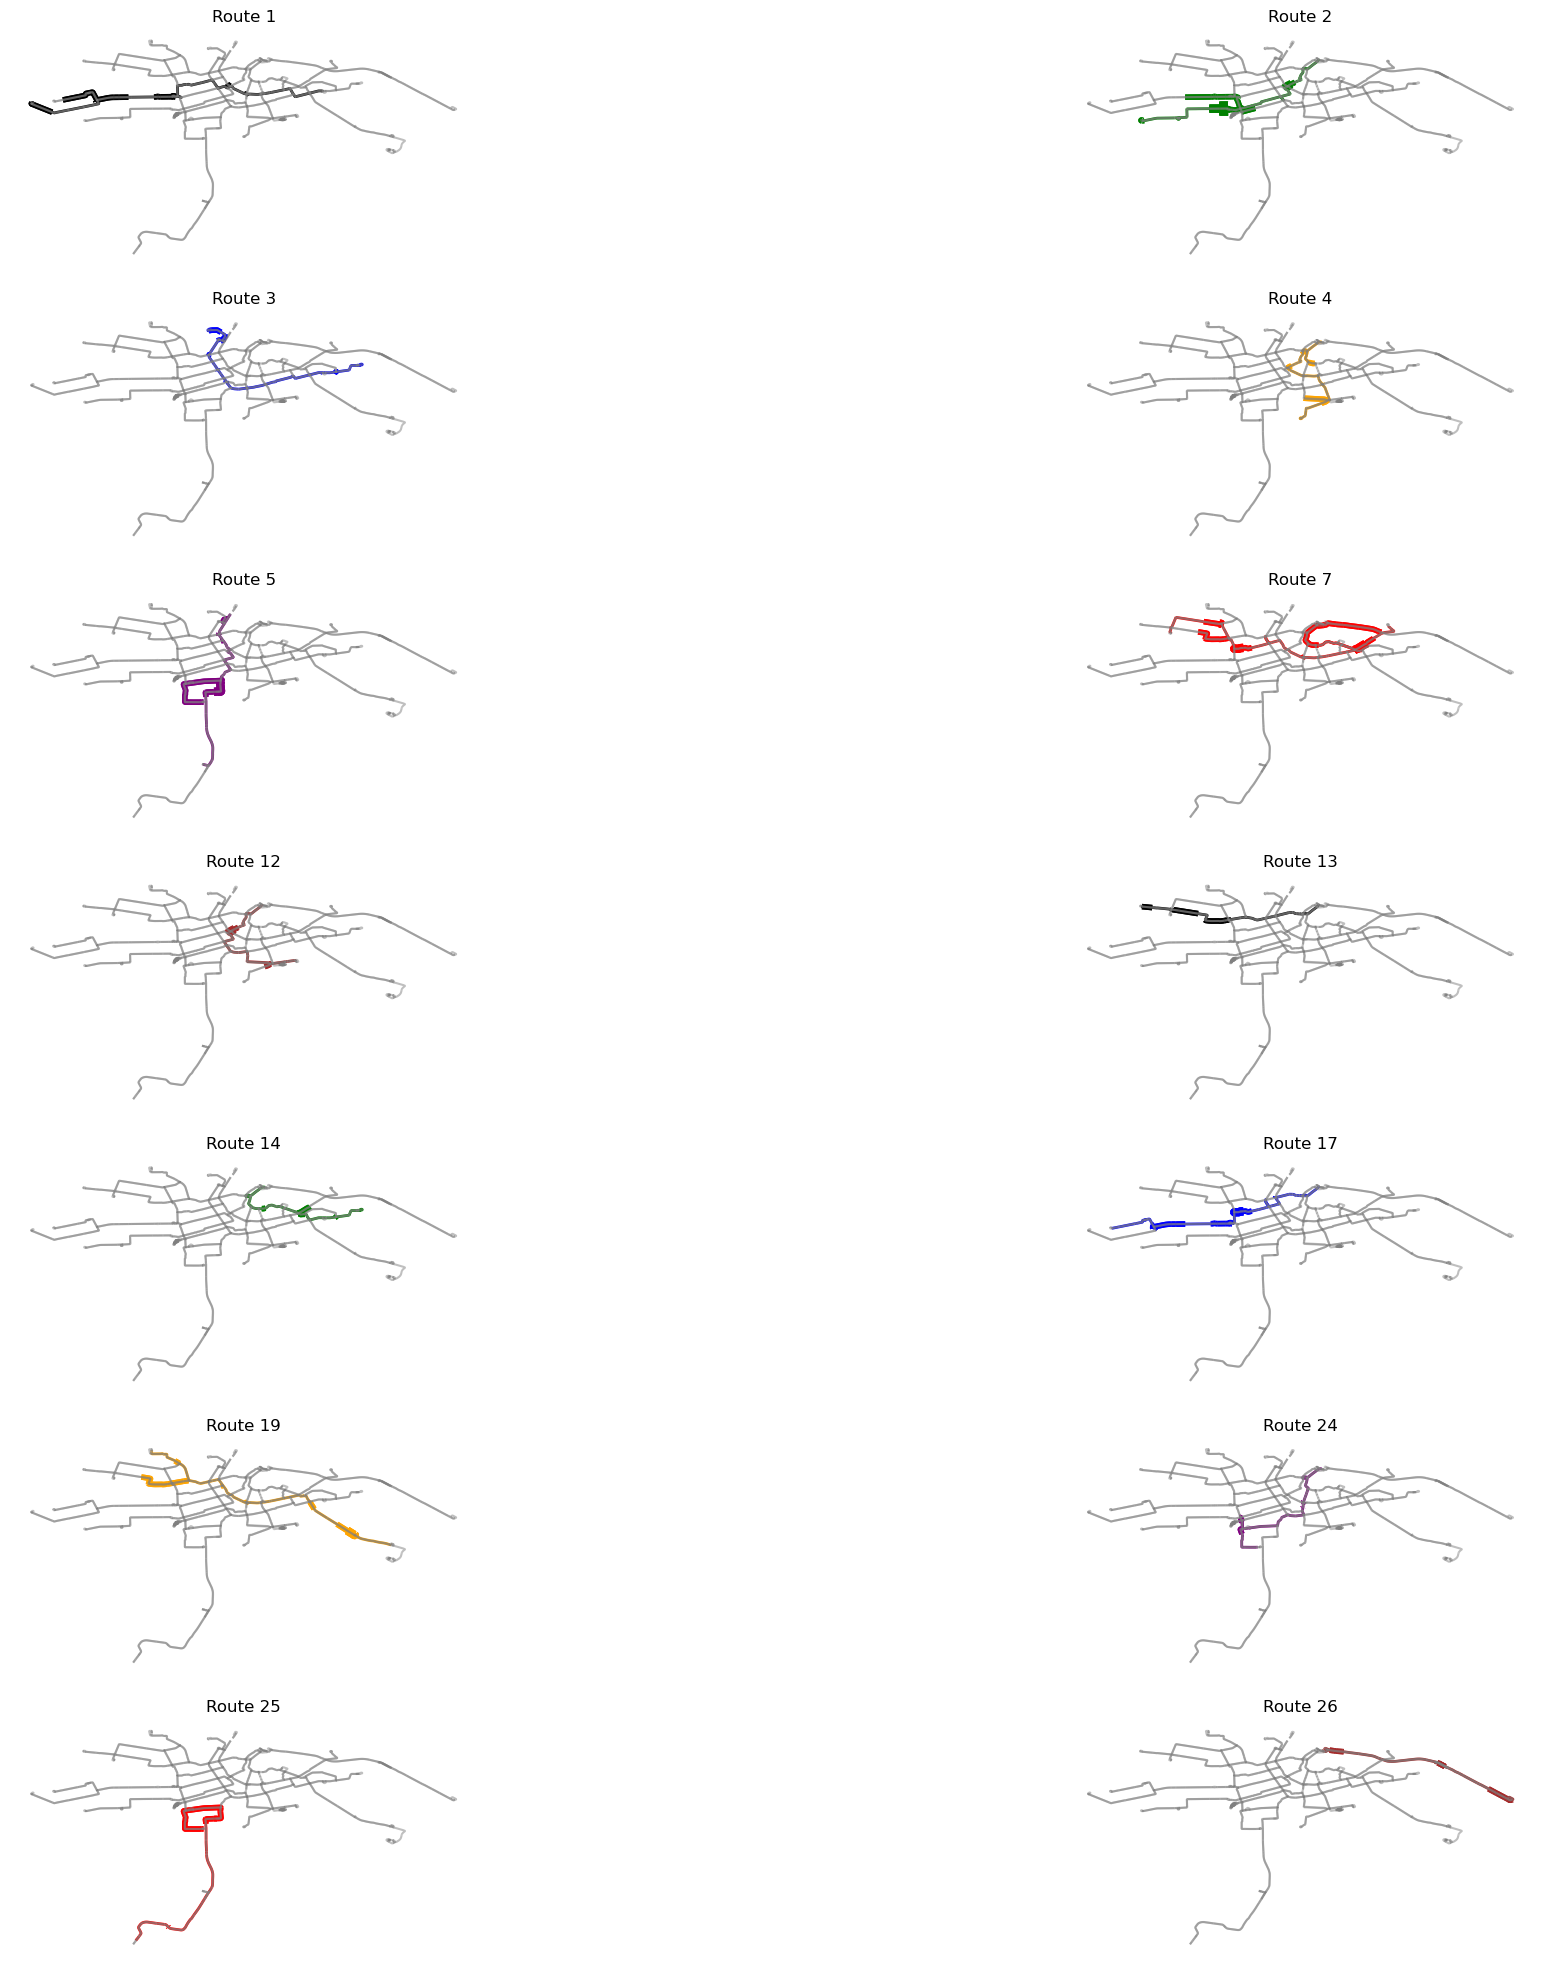

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))
for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_path_edges[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges[i][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

## Test 2-retrive routes compare with edges - but not working May---try to compare with nodes  June

In [43]:
all_routes = routes(osm_path)
all_routes

,osm_id,route,name,ref,geometry
0,15455,bicycle,None,28-29,"MULTILINESTRING ((4.97444 52.27207, 4.97440 52..."
1,15456,bicycle,None,27-28,"MULTILINESTRING ((5.00409 52.27999, 5.00402 52..."
2,15458,bicycle,None,26-27,"MULTILINESTRING ((5.01854 52.27345, 5.01833 52..."
3,15465,bicycle,None,69-71,"MULTILINESTRING ((4.92614 52.27943, 4.92601 52..."
4,15471,bicycle,None,43-65,"MULTILINESTRING ((5.02621 52.30259, 5.02615 52..."
...,...,...,...,...,...
1332,15066540,railway,Schiphollijn,133,"MULTILINESTRING ((4.91478 52.32576, 4.91384 52..."
1333,15258599,ferry,Veer F9: Sluisbuurt → Sporenburg,F9,"MULTILINESTRING ((4.95606 52.37591, 4.95611 52..."
1334,15258600,ferry,Veer F9: Sporenburg → Sluisbuurt,F9,"MULTILINESTRING ((4.94978 52.37455, 4.94980 52..."
1335,15346035,train,32790: Groningen - Schiphol Airport,32790,"MULTILINESTRING ((4.87553 52.33898, 4.87552 52..."


In [44]:
tram_routes = pd.DataFrame(all_routes.loc[all_routes.route == 'tram'])
tram_routes

,osm_id,route,name,ref,geometry
13,31398,tram,Tram 24: Amsterdam Centraal Station => Amsterd...,24,"MULTILINESTRING ((4.89406 52.37387, 4.89361 52..."
14,31530,tram,Tram 2: Amsterdam Centraal Station => Amsterda...,2,"MULTILINESTRING ((4.81102 52.34641, 4.81118 52..."
15,31794,tram,Tram 4: Amsterdam Centraal Station => Amsterda...,4,"MULTILINESTRING ((4.89406 52.37387, 4.89361 52..."
18,32579,tram,Tram 17: Amsterdam Centraal Station => Amsterd...,17,"MULTILINESTRING ((4.80319 52.35911, 4.80313 52..."
19,32615,tram,Tram 26: Amsterdam Centraal Station => Amsterd...,26,"MULTILINESTRING ((4.90035 52.37793, 4.90035 52..."
20,32867,tram,Tram 13: Amsterdam Centraal Station => Amsterd...,13,"MULTILINESTRING ((4.89922 52.37830, 4.89926 52..."
353,4494870,tram,Tram 4: Amsterdam Station RAI => Amsterdam Cen...,4,"MULTILINESTRING ((4.88956 52.33608, 4.88962 52..."
354,4497721,tram,Tram 2: Amsterdam Nieuw Sloten => Amsterdam Ce...,2,"MULTILINESTRING ((4.80985 52.34614, 4.81032 52..."
355,4512710,tram,Tram 13: Amsterdam Geuzenveld => Amsterdam Cen...,13,"MULTILINESTRING ((4.80291 52.37726, 4.80320 52..."
356,4513899,tram,Tram 24: Amsterdam VUmc => Amsterdam Centraal ...,24,"MULTILINESTRING ((4.86582 52.33525, 4.86638 52..."


In [45]:
#gpd.GeoDataFrame(tram_routes.copy()).to_file('tram_routes_amsterdam.gpkg',driver='GPKG')

In [46]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))


# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
# gpd.GeoDataFrame(tram_routes.copy()).plot(ax=ax,color='black',zorder=1)

In [47]:
tram_routes['each_line'] = tram_routes.geometry.apply(lambda x: [Line for Line in x])
# tram_routes

In [48]:
type(tram_routes.iloc[0].geometry)

shapely.geometry.multilinestring.MultiLineString

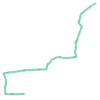

In [49]:
tram_routes.iloc[0].geometry

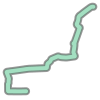

In [50]:
tram_routes.iloc[0].geometry.buffer(0.0015)

In [51]:
tram_routes.iloc[22]

osm_id                                                 8500553
route                                                     tram
name         Tram 1: Amsterdam Osdorp de Aker => Amsterdam ...
ref                                                          1
geometry     (LINESTRING (4.7747567 52.3537327, 4.776554 52...
each_line    [LINESTRING (4.7747567 52.3537327, 4.776554 52...
Name: 622, dtype: object

In [52]:
am_tram_stations = gpd.GeoDataFrame(am_tram_stations.copy())
am_tram_line1_OM = am_tram_stations.loc[am_tram_stations.within(tram_routes.iloc[22].geometry.buffer(0.0015))]
am_tram_line1_MO = am_tram_stations.loc[am_tram_stations.within(tram_routes.iloc[23].geometry.buffer(0.0015))]

In [53]:
am_tram_line1_OM

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
1321,3296373865,stop_position,yes,Matterhorn,POINT (4.77450 52.35387),4.774504,52.353869
1050,1979187101,stop_position,yes,Pilatus,POINT (4.77655 52.35301),4.776554,52.353011
1051,1979187198,stop_position,yes,Inaristraat,POINT (4.78295 52.35045),4.782948,52.350449
1314,3296373458,stop_position,yes,Ecuplein,POINT (4.78816 52.34969),4.788158,52.349694
1320,3296373864,stop_position,yes,Louis Davidsstraat,POINT (4.80852 52.35384),4.808518,52.353839
1322,3296373866,stop_position,yes,Meer en Vaart,POINT (4.80991 52.35637),4.809912,52.35637
1317,3296373861,stop_position,yes,Johan Huizingalaan,POINT (4.82590 52.35781),4.825895,52.357812
1324,3296373870,stop_position,yes,Station Lelylaan,POINT (4.83378 52.35790),4.833784,52.3579
877,1081322915,stop_position,yes,Derkinderenstraat,POINT (4.83975 52.35796),4.839748,52.357957
1325,3296374053,stop_position,yes,Curacaostraat,POINT (4.85070 52.35862),4.850697,52.358618


In [54]:
am_tram_line1_MO

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
1321,3296373865,stop_position,yes,Matterhorn,POINT (4.77450 52.35387),4.774504,52.353869
1050,1979187101,stop_position,yes,Pilatus,POINT (4.77655 52.35301),4.776554,52.353011
1051,1979187198,stop_position,yes,Inaristraat,POINT (4.78295 52.35045),4.782948,52.350449
1314,3296373458,stop_position,yes,Ecuplein,POINT (4.78816 52.34969),4.788158,52.349694
1320,3296373864,stop_position,yes,Louis Davidsstraat,POINT (4.80852 52.35384),4.808518,52.353839
1322,3296373866,stop_position,yes,Meer en Vaart,POINT (4.80991 52.35637),4.809912,52.35637
1317,3296373861,stop_position,yes,Johan Huizingalaan,POINT (4.82590 52.35781),4.825895,52.357812
1324,3296373870,stop_position,yes,Station Lelylaan,POINT (4.83378 52.35790),4.833784,52.3579
877,1081322915,stop_position,yes,Derkinderenstraat,POINT (4.83975 52.35796),4.839748,52.357957
1325,3296374053,stop_position,yes,Curacaostraat,POINT (4.85070 52.35862),4.850697,52.358618


In [55]:
am_all_tram_stations= gpd.GeoDataFrame(am_all_tram_stations.copy())
am_all_tram_line1_OM = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[22].geometry.buffer(0.001))]
am_all_tram_line1_MO = am_all_tram_stations.loc[am_all_tram_stations.within(tram_routes.iloc[23].geometry.buffer(0.001))]

In [56]:
am_all_tram_line1_OM

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
48,46326414,stop_position,yes,Surinameplein,POINT (4.85218 52.35805),4.852183,52.358048
109,237962650,stop_position,yes,Dapperstraat,POINT (4.92894 52.36093),4.928942,52.360931
121,241775832,stop_position,yes,Rijksmuseum,POINT (4.88710 52.36097),4.887104,52.360973
150,285869162,stop_position,yes,Vijzelgracht,POINT (4.89096 52.35990),4.890962,52.359903
171,290930270,stop_position,yes,Derkinderenstraat,POINT (4.84013 52.35794),4.840126,52.357936
...,...,...,...,...,...,...,...
2867,5792105369,stop_position,yes,Frederiksplein,POINT (4.90001 52.35968),4.900010,52.359684
2868,5792762173,stop_position,yes,Vijzelgracht,POINT (4.89254 52.35948),4.892536,52.359477
3214,6933147467,stop_position,yes,Jan Pieter Heijestraat,POINT (4.86579 52.36036),4.865792,52.360364
3371,7197053237,stop_position,yes,Weteringcircuit,POINT (4.89234 52.35933),4.892338,52.359333


In [57]:
am_all_tram_line1_MO

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
48,46326414,stop_position,yes,Surinameplein,POINT (4.85218 52.35805),4.852183,52.358048
109,237962650,stop_position,yes,Dapperstraat,POINT (4.92894 52.36093),4.928942,52.360931
121,241775832,stop_position,yes,Rijksmuseum,POINT (4.88710 52.36097),4.887104,52.360973
150,285869162,stop_position,yes,Vijzelgracht,POINT (4.89096 52.35990),4.890962,52.359903
171,290930270,stop_position,yes,Derkinderenstraat,POINT (4.84013 52.35794),4.840126,52.357936
...,...,...,...,...,...,...,...
2867,5792105369,stop_position,yes,Frederiksplein,POINT (4.90001 52.35968),4.900010,52.359684
2868,5792762173,stop_position,yes,Vijzelgracht,POINT (4.89254 52.35948),4.892536,52.359477
3214,6933147467,stop_position,yes,Jan Pieter Heijestraat,POINT (4.86579 52.36036),4.865792,52.360364
3371,7197053237,stop_position,yes,Weteringcircuit,POINT (4.89234 52.35933),4.892338,52.359333


### retrive routes compare with edges - but not working May

In [ ]:
edges.geometry = edges.geometry.apply(pygeos.to_shapely)  #因为tram_routes中是shapely格式
edges['route'] = ''

In [ ]:
edges

In [ ]:
edges.to_excel('./am_tram_edges.xlsx',header = True, index = False)  
tram_routes.to_excel('./am_tram_routes.xlsx',header = True, index = False)  

In [ ]:
# 将route的ref添加进edges的route列
# 问题可能出在：edges中geometry的linestring部分存在在tram_routes中each_line的multilinestring中， 比如第1005行

In [ ]:
# 方法1
# df_edges=pd.merge(edges,tram_routes,how='left',left_on='geometry',right_on='each_line')
# df_edges=df_edges.loc[:,['osm_id','gemotry','railway','service','id','from_id','to_id','distance','time','weights','to_from','from_to','ref']]
# df31=pd.merge(am_tram_name,am_tram_stations,how='left',left_on='s_name',right_on='name')
# df31=df31.loc[:,['s_name','e_name','geo_x','geo_y']]

In [ ]:
# 方法2
# for n in range(len(tram_routes)):
#     b = gpd.GeoSeries(tram_routes.each_line.iloc[n])
#     for i in range(len(edges)):
#         a = gpd.GeoSeries(edges.geometry.iloc[i])
#         if a.within(b).all():
#             edges.route.iloc[i] = tram_routes.ref.iloc[n]

In [ ]:
# 方法3
#edges['is_on_tram_route'] = edges['geometry'].apply(lambda x: any(x.intersects(route) for route in tram_routes['each_line']))

In [ ]:
#方法4
# for idx, row in edges.iterrows():
#     for each_line in tram_routes.loc['each_line'].tolist():
#         if row['geometry'] in each_line:
#             # 如果第二个表格中的geometry对象在第一个表格中的LineString列表中，则将该行的ref列添加到第二个表格中的对应行中
#             edges.at[idx, 'route'] = tram_routes.loc[tram_routes['each_line'] == each_line, 'ref'].iloc[0]

In [ ]:
for n in range(len(tram_routes)):
    t = 0
    b = tram_routes.each_line.iloc[n]
    t = t + n
    print(t)

In [ ]:
# 方法0
for i in range(len(edges)):
    a = edges.geometry.iloc[i]
    
    for n in range(len(tram_routes)):
        b = tram_routes.each_line.iloc[n]
        c = a in b
        if c > 0:
            edges.route.iloc[i] = tram_routes.ref.iloc[n]      

In [ ]:
#方法0.0
for i in range(len(edges)):
    a = edges.loc[i,'geometry']
    
    for n in range(len(tram_routes)):
        b = tram_routes.iloc[n,tram_routes.columns.get_loc('each_line')]
        if a in b:
            edges.loc[i,'route'] = tram_routes.iloc[n,tram_routes.columns.get_loc('ref')]

In [ ]:
edges

In [ ]:
edges = edges.loc[edges.route != '']
edges

In [ ]:
edges1 = edges.loc[edges.route == '1']
edges1

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


gpd.GeoDataFrame(edges1.copy()).plot(ax=ax,zorder=0)

In [ ]:
a = edges.geometry.loc[0] 
b = tram_routes.each_line.loc[622]
c = tram_routes.each_line.loc[626]

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))


# gpd.GeoSeries(a).plot(ax=ax,zorder=0)
# gpd.GeoSeries(b).plot(ax=ax,color='black',zorder=1)
# gpd.GeoSeries(c).plot(ax=ax,color='blue',zorder=2)

In [ ]:
type(a)

In [ ]:
b

In [ ]:
# a = pygeos.to_shapely(a)
# a

In [ ]:
a in c

In [ ]:
a in b

In [ ]:
d = edges.geometry.loc[1006]
e = tram_routes.each_line.loc[18]
f = tram_routes.each_line.loc[357]

In [ ]:
d in e

In [ ]:
d in f

In [ ]:
edges.geometry = gpd.GeoDataFrame(edges.copy()).geometry.apply(lambda x: Point(x.coords[0]))
tram_routes.each_line = gpd.GeoDataFrame(tram_routes.copy()).geometry.apply(lambda x: Point(x.coords[0]))

# 对于每个edges的坐标点，判断是否在tram_routes中存在
for index, row in edges.iterrows():
    point = row.geometry
    ref_value = tram_routes[tram_routes.intersects(point)].ref.unique()
    
    # 如果存在，则将ref列的值添加到edges中
    if len(ref_value) > 0:
        edges.at[index, 'ref'] = ref_value[0]

## Test1-Step2: get the coordinates of start-end stations accroding to the station name excel,   
## and then calculate the coordinates_pairs and nearest id pairs of start-end points

In [ ]:
stations = tram_stations(osm_path)

In [ ]:
stations

In [ ]:
stations.to_excel('./am_stations.xlsx',header = True, index = False)  

In [ ]:
am_tram_stations = am_tram_stations(stations)

In [ ]:
am_tram_stations

In [ ]:
am_tram_stations.to_excel('./am_tram_stations.xlsx',header = True, index = False)  

In [ ]:
am_tram_name = pd.read_excel(r'C:/projects/UTNCE/data/am_tram_name.xlsx')

In [ ]:
am_tram_coordinates = s_e_tram_coordinates(am_tram_stations, am_tram_name)
am_tram_coordinates

In [ ]:
am_tram_coordinates_pairs = s_e_coordinates_pairs(am_tram_coordinates)

In [ ]:
am_tram_coordinates_pairs

In [ ]:
am_tram_id_pairs = id_pairs(am_tram_coordinates_pairs,nodes)
am_tram_id_pairs

## Test1-Step3: calculate shortest pathes for all id pairs and visulize the tram map with the used time of each edges

In [ ]:
G = create_ground_graph(edges, nodes)

In [ ]:
am_tram_shortest_path_pairs = all_shortest_paths(am_tram_id_pairs,edges)
am_tram_shortest_path_pairs

In [ ]:
duplicate_row_count, am_tram_shortest_path_edges, edges = edges_with_count_weight(am_tram_shortest_path_pairs,edges)
#am_tram_shortest_path_edges, duplicate_row_count

In [ ]:
# am_tram_shortest_path_edges.to_excel('./am_tram_shortest_path_edges.xlsx',header = True, index = False) 

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(am_tram_shortest_path_edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=(am_tram_shortest_path_edges['count_weight'])*2)

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
# gpd.GeoDataFrame(edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=(edges['count_weight'])*2)

## Test1-Step4: draw each route with the base map of Amsterdam tram

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))
for i, ax in enumerate(axes.flat):
    if i < 14:
        route, route_weight, route_edges = shortest_path(G, am_tram_id_pairs.loc[i, 's_id'], am_tram_id_pairs.loc[i, 'e_id'], edges, weight = "weights")
    
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='red')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='green')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='blue')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='orange')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(route_edges.copy()).plot(ax=ax, color='pink')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()

## Test1-Step5: calculate maximum flow for each route of Amsterdam subway

In [ ]:
route_capacity = pd.DataFrame({'metro_num': [5.0, 4.0, 7.0, 6.0, 8.0, 6.0, 9.0, 4.0, 3.0, 5.0, 6.0, 7.0, 5.0, 6.0]})

In [ ]:
edges, route_edges, flow_value_dict, flow_value = max_flow_am_tram(edges, nodes, route_capacity, am_tram_id_pairs, G)

In [ ]:
edges

# Old test records

1 Muiderpoortstation,Matterhorn
2 Centraal Station_B,Oudenaardeplantsoen
3 Flevopark,Van Hallstraat
4 Centraal Station_A,Station RAI
5 Eerste Marnixdwarsstraat,Amstelveen Stadshart
7 Azartplein,Sloterpark
12 Centraal Station_B,Amstelstation
13 Centraal Station_B,Lambertus Zijlplein
14 Centraal Station_A,Flevopark
17 Centraal Station_B,Dijkgraafplein
19 Sniep,Station Sloterdijk
24 Centraal Station_A,De Boelelaan/VU
25 Station Zuid,Westwijk
26 Centraal Station_A,IJburg

## 循环的形式实现am_tram_coordinates_pairs，但是有一个问题，缺失的终点站被起始站坐标补齐，已经解决-因为pbf文件一开始不完整

In [ ]:
am_tram_coordinates_pairs = pd.DataFrame(['s_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y'])
for index, row in am_tram_name.iterrows():
    s_station_name = row['s_name']
    matching_stations1 = am_tram_stations[am_tram_stations['name'] == s_station_name]
    if len(matching_stations1) > 0:
        matching_station = matching_stations1.iloc[0]
        am_tram_coordinates_pairs.loc[index, 's_coordinates_x'] = matching_station['geo_x']
        am_tram_coordinates_pairs.loc[index, 's_coordinates_y'] = matching_station['geo_y'] 

    e_station_name = row['e_name']
    matching_stations2 = am_tram_stations[am_tram_stations['name'] == e_station_name]
    if len(matching_stations2) > 0:
        matching_station = matching_stations2.iloc[0]
        am_tram_coordinates_pairs.loc[index, 'e_coordinates_x'] = matching_station['geo_x']
        am_tram_coordinates_pairs.loc[index, 'e_coordinates_y'] = matching_station['geo_y']


am_tram_coordinates_pairs

## 替代excel文件：am_tram_coordinates  #am_tram_coordinates = pd.read_excel(r'./am_tram_coordinates_pairs.xlsx')

In [ ]:
stations = tram_stations(osm_path)

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(stations.copy()).plot(ax=ax,color='black',zorder=1)

In [ ]:
# stations.to_excel('./am_tram_stations.xlsx',header = True, index = False,sheet_name = 'mydata')  

In [ ]:
stations['geo_x'] = stations.geometry.x
stations['geo_y'] = stations.geometry.y

In [ ]:
sorted_stations = stations.sort_values(by='geo_x')

In [ ]:
stations_drop = sorted_stations [sorted_stations ['name'] != 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
stations_drop

In [ ]:
station_cetralB = sorted_stations[sorted_stations['name'] == 'Centraal Station'].drop_duplicates(subset=['name'], keep='first')
station_cetralB.iloc[0, 2] = 'Centraal Station_B'
station_cetralB

In [ ]:
station_cetralA = gpd.GeoDataFrame(sorted_stations[sorted_stations['name'] == 'Centraal Station'].iloc[-2]).T
station_cetralA.iloc[0, 2] = 'Centraal Station_A'
station_cetralA

In [ ]:
df_stations_drop = pd.DataFrame(stations_drop)
df_station_cetralB = pd.DataFrame(station_cetralB)
df_station_cetralA = pd.DataFrame(station_cetralA)
am_tram_stations = pd.concat([df_stations_drop, df_station_cetralB, df_station_cetralA])
am_tram_stations

In [ ]:
am_tram_stations = am_tram_stations.sort_values(by='geo_y')
am_tram_stations

In [ ]:
am_tram_name = pd.read_excel(r'./am_tram_name.xlsx')

In [ ]:
am_tram_name

In [ ]:
df31=pd.merge(am_tram_name,am_tram_stations,how='left',left_on='s_name',right_on='name')
df31=df31.loc[:,['s_name','e_name','geo_x','geo_y']]
df32=pd.merge(df31,am_tram_stations,how='left',left_on='e_name',right_on='name')
df32.loc[:,['s_name','e_name','geo_x_x','geo_y_x','geo_x_y','geo_y_y']]

# df32=pd.merge(am_tram_name,am_tram_stations,how='inner',left_on='e_name',right_on='name')
# df32=df32.loc[:,['e_name','geo_x','geo_y']]
# df3=pd.concat([df31,df32])

In [ ]:
am_tram_coordinates = pd.DataFrame()
am_tram_coordinates = df32.loc[:,['s_name','e_name','geo_x_x','geo_y_x','geo_x_y','geo_y_y']]
am_tram_coordinates.columns = ['s_name','e_name','s_coordinates_x', 's_coordinates_y', 'e_coordinates_x', 'e_coordinates_y']

In [ ]:
am_tram_coordinates

In [ ]:
# after using the Amsterdam.bbbike.pbf, there is no need to do this
# am_tram_coordinates.loc[12,'e_coordinates_x'] = 4.8310348
# am_tram_coordinates.loc[12,'e_coordinates_y'] = 52.2748113
# am_tram_coordinates   